## Setting

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
import os
os.chdir("./MtoG1_analysis_code")
print(os.getcwd())
!pwd

/Volumes/UKJIN_SSD/MtoG1_analysis_code
/Volumes/UKJIN_SSD/MtoG1_analysis_code


In [3]:
# Import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, subprocess

In [4]:
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

# Functions for generalization

In [5]:
import copy

def callAPAoverLoop(coolFileDir, coolFileName, loopFileDir, loopFileName, minDiag, byDistance, balance, ooe):
	# minDist = minimun distance in kb to plot in APA
	# Load cool file
	cool_file = coolFileDir + '/' + coolFileName + '_KR.cool'
	clr = cooler.Cooler(f'{cool_file}')
	# Load loop file
	loop_file = loopFileDir + '/' + loopFileName + '.bedpe'
	loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
	loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
	# Load expected table
	exp_file = coolFileDir + '/' + coolFileName + '_KR_exp.tsv'
	exp_df = pd.read_csv(exp_file, delimiter='\t')

	# keep loop count
	nloops = len(loop)
	
	# Pileup
	if ooe:
		pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
							 min_diag = minDiag, by_distance = byDistance,
							 nproc = 12, 
							 clr_weight_name = balance,
							 ooe = True, expected_df = exp_df)
	else:
		 pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
							 min_diag = minDiag, by_distance = byDistance,
							 nproc = 12, 
							 clr_weight_name = balance,
							 ooe = False)       
	return pup, nloops

def get_corner_score(pup, flank = 1):
	amap = pup["data"][0]
	c = amap.shape[0] / (flank*2 + 1)
	c = int(c)
	central = np.nanmean(amap[flank*c:-flank:c, flank*c:-flank*c])
	topRight = np.nanmean(amap[:c, -c:])
	cornerScore = central/topRight
	return cornerScore, central, topRight


def drawAPA(pup, nloops, scale, colormap, vmax, vmin, fileDir, fileName):
	puptemp = copy.deepcopy(pup)
	if scale == 'log10':
		puptemp.data[0] = np.log10(puptemp.data[0])
	# Make figure
	# Enrichment score is calculated by ratio of C(obs/exp) to R (obs/exp) before doing any form of log transform
	corner = str(round(get_corner_score(pup, flank = 2)[0], 2))
	
	if vmax == False:
		fg1 = plotpup.plot(puptemp,
						   cmap = colormap,
						   score = False, 
						   scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)
		ax = fg1.ax
		ax.text(
			0.95, 0.95,                   # 95% from left, 95% from bottom
			f"corner score: {corner}",
			va="top", ha="right",
			transform=ax.transAxes,       # ← important!
			size=4
		)
		ax.text(
			0.95, 0.85,
			f"n loops: {nloops}",
			va="top", ha="right",
			transform=ax.transAxes,
			size=4
		)
	else:
		fg1 = plotpup.plot(puptemp,
				   cmap = colormap,
				   score = False, vmax = vmax, vmin = vmin,
				   scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)
		ax = fg1.ax
		ax.text(
			0.95, 0.95,                   # 95% from left, 95% from bottom
			f"corner score: {corner}",
			va="top", ha="right",
			transform=ax.transAxes,       # ← important!
			size=4
		)
		ax.text(
			0.95, 0.85,
			f"n loops: {nloops}",
			va="top", ha="right",
			transform=ax.transAxes,
			size=4
		)
	file = fileDir + '/' + fileName + '.svg'
	fg1.savefig(file, format = 'svg')
	return True


# APA plot

In [6]:
# LOADING COOL FILE
coolDir = '/Volumes/UKJIN_SSD/data/cool_norm_pooled'
figDir = '/Volumes/UKJIN_SSD/figure/microcompartment'
loopDir = '/Volumes/UKJIN_SSD/data/microcompartment'

os.makedirs(figDir, exist_ok=True)


In [ ]:
for res in ['25000']:
	for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
		try:
			pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
					loopDir, 'G1DMSO_pooled_microcompartment_' + res + 'bp',
					minDiag = 2, byDistance = False,
					balance = 'weight', ooe = True)
			fileName = 'APA_' + sample + '_microcompartment_G1DMSOcalled_' + res + 'bp'
			drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
					fileDir = figDir, fileName = fileName)
			# drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = 1, vmin = 0,
			#           fileDir = figDir, fileName = fileName + '_minmax')
		except:
			print(f"Failed to process {sample} at resolution {res}")
			continue

for res in ['10000']:
	for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
		try:
			pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
					loopDir, 'G1dTAG_pooled_microcompartment_' + res + 'bp',
					minDiag = 2, byDistance = False,
					balance = 'weight', ooe = True)
			fileName = 'APA_' + sample + '_microcompartment_G1dTAGcalled_' + res + 'bp'
			drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
					fileDir = figDir, fileName = fileName)
			# drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = 1, vmin = 0,
			#           fileDir = figDir, fileName = fileName + '_minmax')
		except:
			print(f"Failed to process {sample} at resolution {res}")
			continue


Failed to process G1DMSO_pooled at resolution 10000
Failed to process G1dTAG_pooled at resolution 10000
Failed to process G1DMSO_pooled at resolution 10000
Failed to process G1dTAG_pooled at resolution 10000


python(82311) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82312) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82313) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82314) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82318) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82320) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82321) Malloc

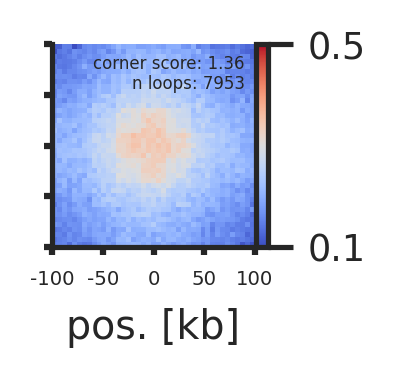

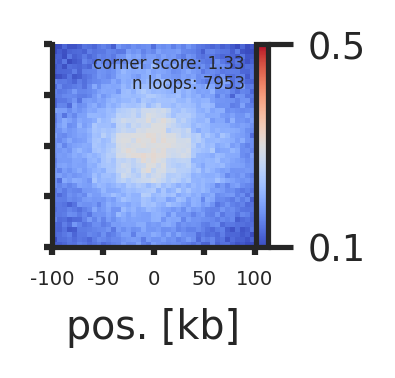

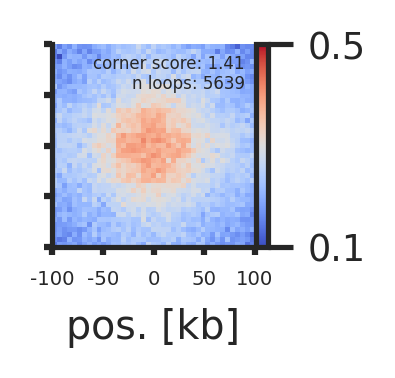

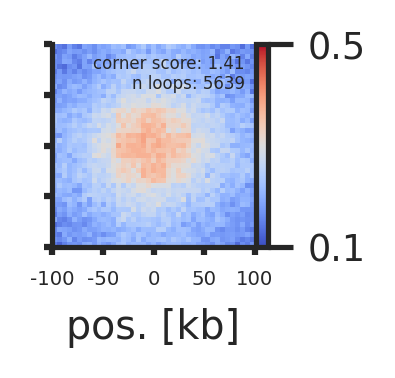

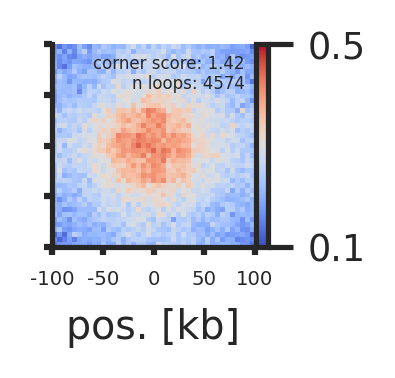

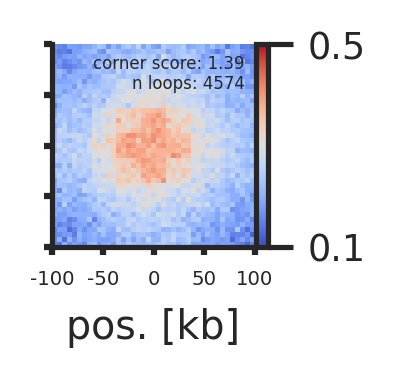

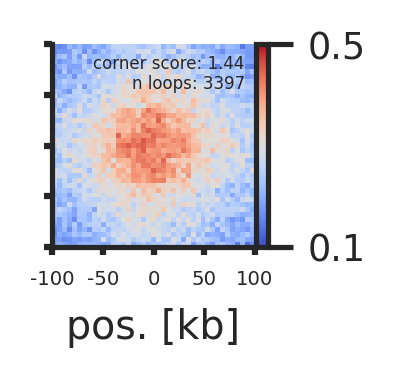

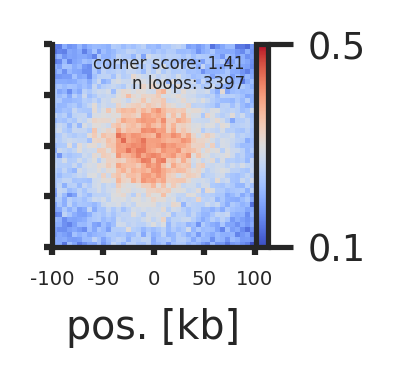

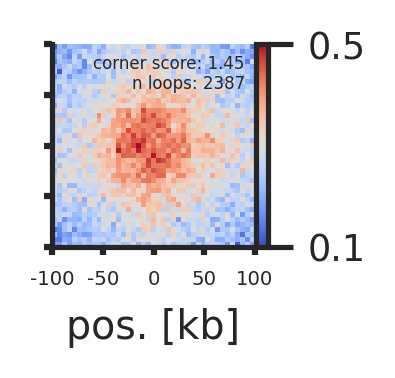

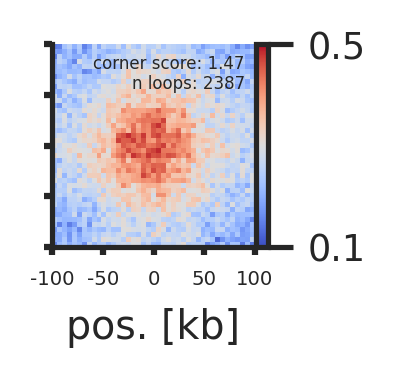

In [8]:
for size in ['2Mb_10Mb', '10Mb_20Mb', '20Mb_30Mb', '30Mb_40Mb', '40Mb_50Mb']:
	for res in ['5000']:
		for sample in ['G1DMSO_pooled', 'G1dTAG_pooled']:
			try:
				pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
						loopDir, 'microcompartment_union_25000bp_postprocessed_' + size,
						minDiag = 2, byDistance = False,
						balance = 'weight', ooe = True)
				fileName = 'APA_' + sample + '_microcompartment_union_postprocessed_' + res + 'bp_' + size
				# drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
				# 		fileDir = figDir, fileName = fileName)
				drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = 0.5, vmin = 0.1,
						fileDir = figDir, fileName = fileName + '_minmax')
			except:
				print(f"Failed to process {sample} at resolution {res}")
				continue